In [53]:
import sys
sys.path.append('..')

from hsja import hop_skip_jump_attack

# Helper imports
from data import CIFAR10, IMAGENETTE
import utils

# Numerical computing and display imports
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

# Other imports
from datetime import datetime
import os

In [54]:
# Load and Prepare the Data
folder_path = '../../images/'
dataset = 'imagenette'    
if dataset == 'cifar10':
    images = CIFAR10()
if dataset == 'imagenette':
    images = IMAGENETTE()
x = images.load()
images.save_to_disk(x, folder_path, num_images=100)
folder_path = utils.move_data_to_temp_ram(folder_path, ram_size_mb=50)

[INFO] Images saved
[INFO] RAM Disk Already Exists...
[INFO] RAM Disk Cleared...
[INFO] Files moved to temp RAM...


In [55]:
def nes_gradient_estimate(img, mean=0, std=0.1, sigma=0.1):
    def hamming_dist_loss(img, perterbed_img):
        # Compute the hamming distance 
        orig_hash = utils.compute_hash(img)
        perterbed_hash = utils.compute_hash(perterbed_img)
        return utils.distance(orig_hash, perterbed_hash, 'hamming')
    
    noise_plus, noise_minus = np.random.normal(loc=mean, scale=std, size=img.shape), np.random.normal(loc=mean, scale=std*2, size=img.shape)
    noise = (noise_plus+noise_minus)/2
    img_plus = img + sigma*noise_plus*255
    img_minus = img - 255*sigma*noise_minus

    plus_loss, minus_loss = hamming_dist_loss(img, img_plus), hamming_dist_loss(img, img_minus)

    est_grads = np.zeros(img.shape)
    est_grads += plus_loss*noise
    est_grads -= minus_loss*noise

    return est_grads

In [65]:
idx = 8
img_path = f'../../images/{idx}.jpeg' 
img = utils.load_img(img_path)

eps = 0.05
est_grad = nes_gradient_estimate(img, sigma=0.9)
grad_direction = np.sign(est_grad)
perturbed_img = img + 255*eps*grad_direction
perturbed_img = np.clip(perturbed_img.astype(np.uint8), 0, 255)

simba_filename = '../../images/perturbed.jpeg'
utils.save_img(simba_filename, perturbed_img)
hsja_max_steps = 5
grad_queries = 100
l2_threshold = 20
hamming_threshold = 10

(adv_img, hsja_queries) = hop_skip_jump_attack(orig_img_path=img_path, 
    target_img_path=simba_filename, 
    max_iters=hsja_max_steps, 
    grad_queries=grad_queries, 
    l2_threshold=l2_threshold, 
    hamming_threshold=hamming_threshold)

orig_hash = utils.compute_hash(img)
adv_hash = utils.compute_hash(adv_img)
final_hamming = utils.distance(orig_hash, adv_hash, 'hamming')

HSJA Iteration: 1
[INFO] Starting Boundary Search...
Hamming Dist: 56
L2 Dist: 29.67469818579218
Hamming Dist: 49
L2 Dist: 113.06814091767575
Hamming Dist: 20
L2 Dist: 56.534070458837874
Hamming Dist: 7
L2 Dist: 28.26703522941894
Hamming Dist: 13
L2 Dist: 28.26703522941894
Hamming Dist: 11
L2 Dist: 21.200276422064196
[INFO] Boundary Search Complete...
[INFO] Stepsize too small...


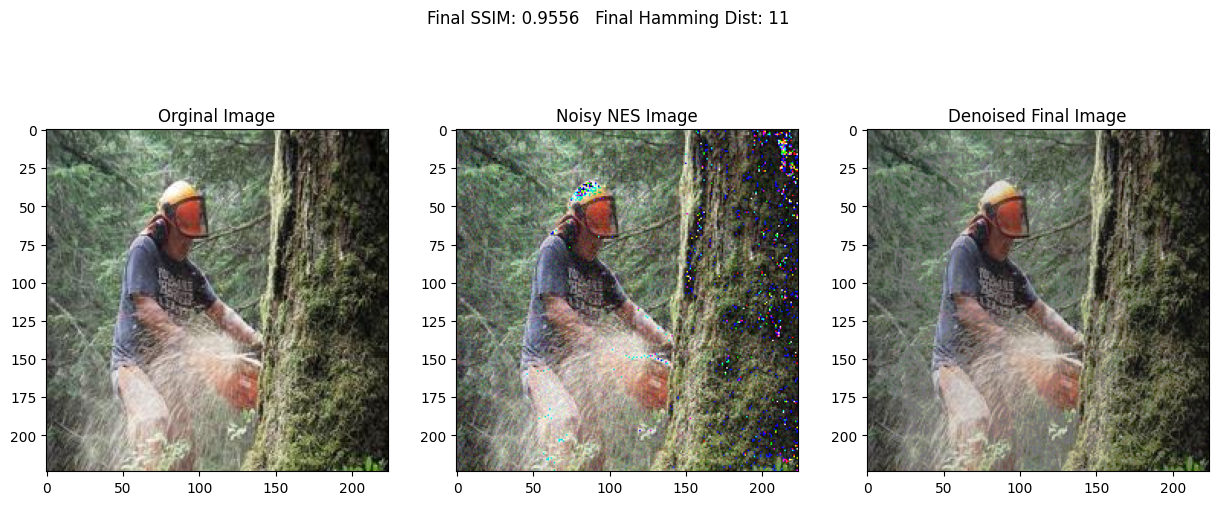

In [66]:
def plot_results(orig_img, simba_img, adv_img, ssim, hamming_dist):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))
    fig.suptitle(f'Final SSIM: {ssim:.4f}   Final Hamming Dist: {hamming_dist}')
    ax1.imshow(orig_img)
    ax1.set_title('Orginal Image') 
    ax2.imshow(simba_img)
    ax2.set_title('Noisy NES Image')
    ax3.imshow(adv_img.astype(np.uint8))
    ax3.set_title('Denoised Final Image')

# Show the images/results
plot_results(img, perturbed_img, adv_img, utils.distance(img, adv_img.astype(np.uint8), "ssim"), final_hamming)